# Zadanie 1
Za pomocą odpowiednich symulacji zbadać moc testów Shapiro-Wilka, Kołmogorowa-Smirnowa oraz testu chi-kwadrat w przypadku, gdy dane pochodzą z rozkładu t-Studenta lub innej klasy rozkładów symetrycznych.

Wyniki należy przedstawić na wykresach w zależności od:

- liczby danych,
- liczby stopni swobody generowanego rozkładu.

Stopnie swobody: 100%|██████████| 6/6 [00:24<00:00,  4.01s/it]


   df   n                  test  power
0   1  10         Shapiro-Wilka  0.582
1   1  10  Kołmogorowa-Smirnowa  0.165
2   1  10                    χ²  0.000
3   1  30         Shapiro-Wilka  0.959
4   1  30  Kołmogorowa-Smirnowa  0.726


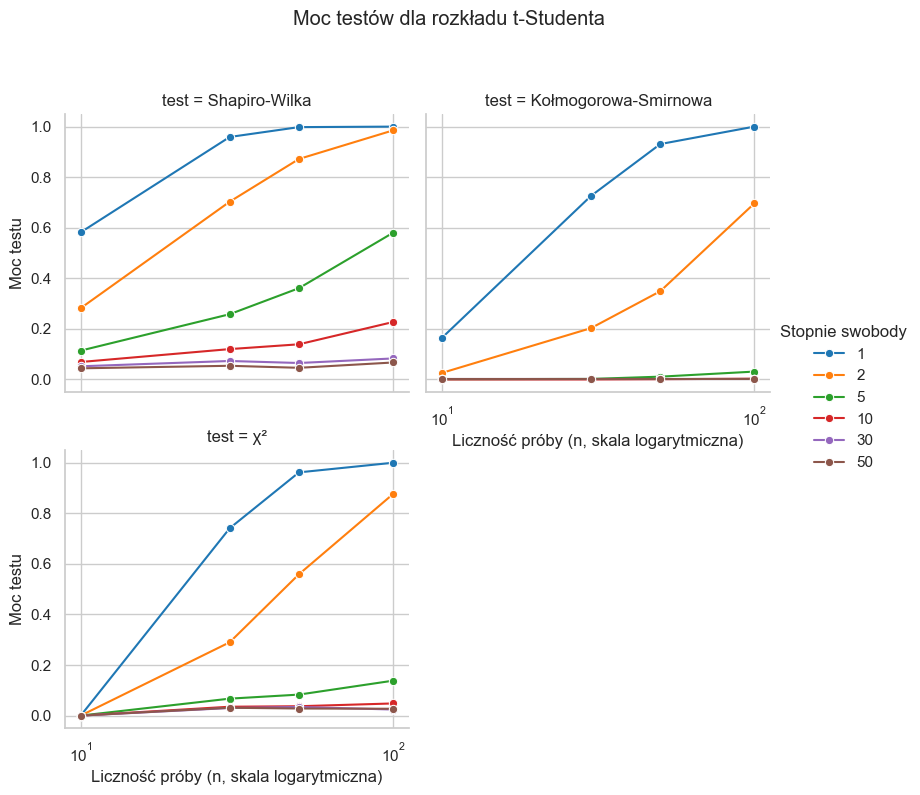

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Pasek postępu

sns.set(style="whitegrid")

# Parametry symulacji
df_values = [1, 2, 5, 10, 30, 50]    # Stopnie swobody
n_values = [10, 30, 50, 100]         # Liczba danych
k = 1000                          				# Liczba symulacji dla każdej kombinacji

# Funkcji testowe
def test_shapiro(x):
	return stats.shapiro(x)[1]

def test_ks(x):
	mu, sigma = np.mean(x), np.std(x, ddof=1)
	return stats.kstest(x, 'norm', args=(mu, sigma))[1]

def test_chi2(x):
	n = len(x)
	nbins = int(np.sqrt(n))
	# Ilość koszy
	bins = np.histogram_bin_edges(x, bins=nbins)
	obs, _ = np.histogram(x, bins=bins)
	# Parametry rozkładu normalnego na podstawie x
	mu, sigma = np.mean(x), np.std(x, ddof=1)
	# Obliczanie oczekiwanego prawdopodobieństwa dla każdego przedziału
	cdf_bins = stats.norm.cdf(bins, loc=mu, scale=sigma)
	expected_probs = np.diff(cdf_bins)
	expected = expected_probs * n
	# Tylko przedziały z prawidłową liczebnością
	valid = expected >= 5
	if np.sum(valid) <= 1:
		return 1.0   # Brak odrzucenia
	obs_valid = obs[valid]
	expected_valid = expected[valid]
	# Normalizacja oczekiwanej liczby tak, aby ich suma była równa liczbie zaobserwowanej
	expected_norm = expected_valid * (obs_valid.sum() / expected_valid.sum())
	_, p_val = stats.chisquare(f_obs=obs_valid, f_exp=expected_norm)
	return p_val

test_functions = {
	"Shapiro-Wilka": test_shapiro,
	"Kołmogorowa-Smirnowa": test_ks,
	"χ²": test_chi2
}

# Funkcja symulująca moc testu
def compute_power(test_func, df, n, k):
	p_vals = []
	for _ in range(k):
		# Losujemy próbkę z rozkładu t-Studenta
		x = stats.t.rvs(df, size=n)
		p = test_func(x)
		p_vals.append(p)
	# Moc testu to odsetek prawidłowych odrzuceń przy poziomie 0.05.
	power = np.mean(np.array(p_vals) < 0.05)
	return power

results = []

# Pętla po wszystkich kombinacjach: stopnie swobody, liczebność próby i rodzaj testu
for df_val in tqdm(df_values, desc="Stopnie swobody"):
	for n in n_values:
		for test_name, func in test_functions.items():
			power = compute_power(func, df_val, n, k)
			results.append({
				"df": df_val,
				"n": n,
				"test": test_name,
				"power": power
			})

df_results = pd.DataFrame(results)

print(df_results.head())

g = sns.FacetGrid(df_results, col="test", hue="df", sharey=True,
col_wrap=2, height=4, palette="tab10")
g.map(sns.lineplot, "n", "power", marker="o")
g.set(xscale="log")
g.set_axis_labels("Liczność próby (n, skala logarytmiczna)", "Moc testu")
g.add_legend(title="Stopnie swobody")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Moc testów dla rozkładu t-Studenta")
plt.show()

# Zadanie 2
Zbadać odsetek odrzuceń prawdziwej hipotezy głównej (błąd I rodzaju) w testach Kołmogorowa-Smirnowa oraz χ2 dla danych pochodzących z rozkładu χ2 o k stopniach swobody, porównując klasyczne testowanie z metodą PIT (Probability Integral Transform).

Analizę należy przeprowadzić w zależności od:
- liczby danych,
- liczby stopni swobody.

df: 100%|██████████| 6/6 [00:46<00:00,  7.69s/it]


   df   n                  test     method  error
0   1  10  Kolmogorowa-Smirnowa  Klasyczne  0.039
1   1  10  Kolmogorowa-Smirnowa        PIT  0.057
2   1  10                   X^2  Klasyczne  0.000
3   1  10                   X^2        PIT  0.000
4   1  30  Kolmogorowa-Smirnowa  Klasyczne  0.048


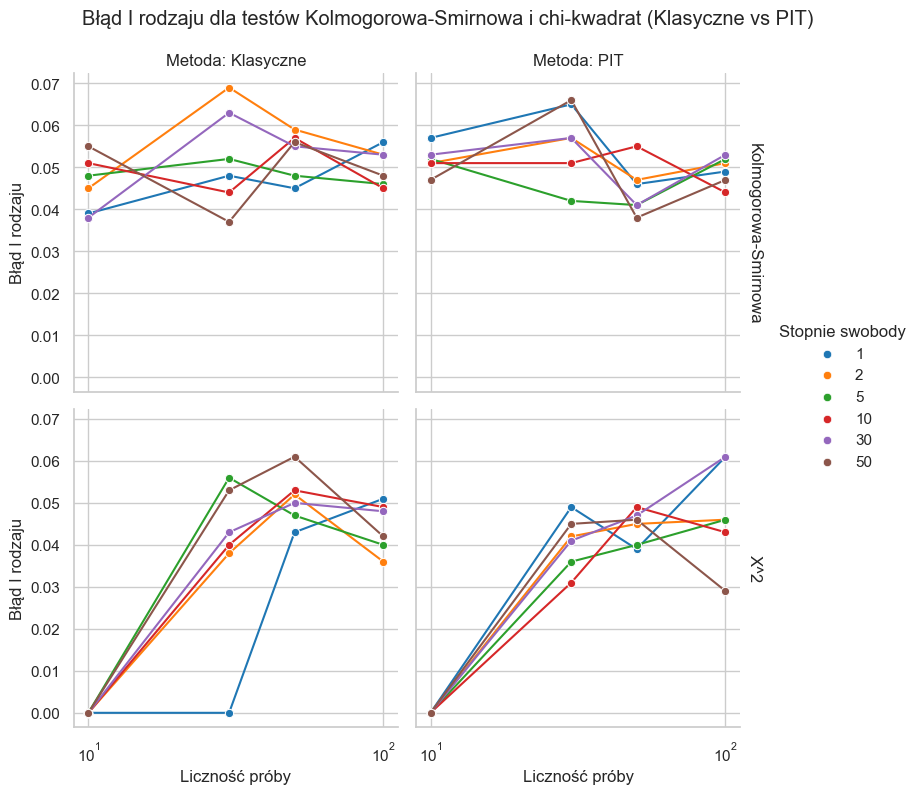

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")

# Parametry symulacji
stopnie_swobody = [1, 2, 5, 10, 30, 50]       # Stopnie swobody (df)
n_values = [10, 30, 50, 100]                  # Liczebność próbek
k = 1000                              			         # Liczba symulacji dla każdej kombinacji
tests = ["Kolmogorowa-Smirnowa", "X^2"]       # Rodzaje testów
methods = ["Klasyczne", "PIT"]              	 # Metody: klasyczna lub z PIT

# Pomocnicze funkcje do testów i PIT
def pit_transform(x, df):
    return stats.chi2.cdf(x, df)

def test_ks(x, df=None, pit=False):
    if pit:
        return stats.kstest(x, 'uniform')[1]
    else:
        return stats.kstest(x, 'chi2', args=(df,))[1]

def test_chi2(x, df=None, pit=False):
    n = len(x)
    if pit:
        bins = np.linspace(0, 1, int(np.ceil(np.sqrt(n)) + 1))
        expected = np.diff(bins) * n
    else:
        nbins = int(np.sqrt(n))
        bins = np.histogram_bin_edges(x, bins=nbins)
        expected = np.diff(stats.chi2.cdf(bins, df)) * n

    obs, _ = np.histogram(x, bins=bins)
    valid = expected >= 5
    if np.sum(valid) <= 1:
        return 1.0 
    obs = obs[valid]
    expected = expected[valid]
    if len(obs) > 1:
        expected_norm = expected * (obs.sum() / expected.sum())
        try:
            _, p_val = stats.chisquare(f_obs=obs, f_exp=expected_norm)
            return p_val
        except Exception:
            return 1.0
    else:
        return 1.0
        
def type1_error(test_func, df, n, k, pit=False):
    p_values = []
    for i in range(k):
        # Próbka z rozkładu chi-kwadrat
        x = np.random.chisquare(df, size=n)
        if pit:
            x = pit_transform(x, df)
        p = test_func(x, df=df, pit=pit)
        p_values.append(p)
    return np.mean(np.array(p_values) < 0.05)

rows = []

for df_val in tqdm(stopnie_swobody, desc="df"):
    for n in n_values:
        for test in tests:
            for method in methods:
                pit_flag = (method == "PIT")
                # dla "Kolmogorowa-Smirnowa" test_ks, a dla "X^2" test_chi2.
                test_func = test_ks if test == "Kolmogorowa-Smirnowa" else test_chi2
                error = type1_error(test_func, df_val, n, k, pit=pit_flag)
                rows.append({
                    "df": df_val,
                    "n": n,
                    "test": test,
                    "method": method,
                    "error": error
                })

df_results = pd.DataFrame(rows)
print(df_results.head())


g = sns.FacetGrid(df_results, row="test", col="method", hue="df",
height=4, palette="tab10", margin_titles=True)
g.map(sns.lineplot, "n", "error", marker="o")
g.map(sns.scatterplot, "n", "error")

for ax in g.axes.flatten():
    ax.set_xscale("log")
    ax.set_xlabel("Liczność próby")
    ax.set_ylabel("Błąd I rodzaju")

g.set_titles(col_template="Metoda: {col_name}", row_template="{row_name}")
g.add_legend(title="Stopnie swobody")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Błąd I rodzaju dla testów Kolmogorowa-Smirnowa i chi-kwadrat (Klasyczne vs PIT)")
plt.show()

# Zadanie 3
Zbadać moc testu Kołmogorowa-Smirnowa dla próbek pochodzących z rozkładów X^2 o różnych stopniach swobody, przesuwając dane tak, by miały tę samą wartość oczekiwaną. Wyniki należy zilustrować na wykresach, uwzględniając:

- liczebność próbek (różne dla każdej próbki),
- liczbę stopni swobody.

Stopnie swobody: 100%|██████████| 6/6 [00:18<00:00,  3.05s/it]


   df    n  power
0   1   10  0.089
1   1   30  0.752
2   1   50  0.989
3   1  100  1.000
4   2   10  0.017


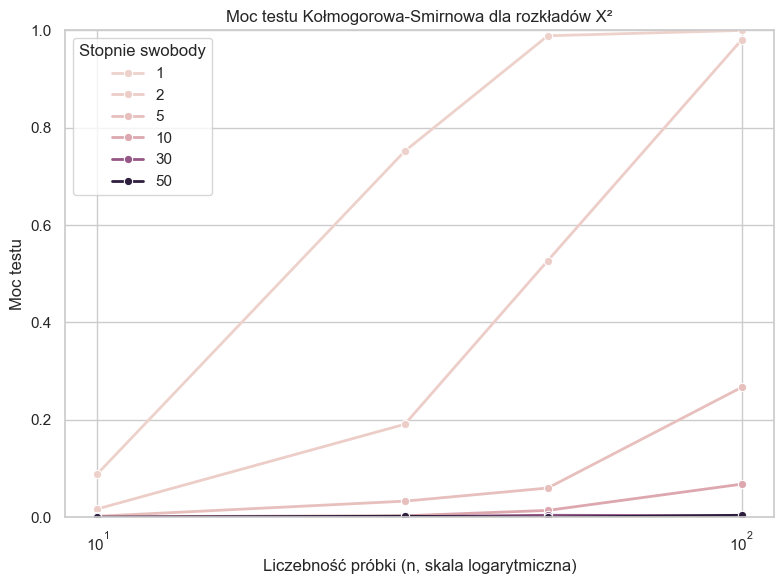

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")

# Parametry
alpha = 0.05                                         # Poziom istotności
stopnie_swobody = [1, 2, 5, 10, 30, 50]   # Stopnie swobody (df)
n_values = [10, 30, 50, 100]              # Liczebności próbek
k = 1000                                             # Liczba symulacji dla każdej konfiguracji

def compute_power_ks(df, n, k):
    p_values = []
    for i in range(k):
        # Próbka z rozkładu chi-kwadrat
        sample_chisq = np.random.chisquare(df, size=n)
        # Przesuwamy próbkę, żeby miała wartość oczekiwaną równą df:
        sample_shifted = sample_chisq - np.mean(sample_chisq) + df
        # Sprawdzamy zgodność z rozkładem normalnym o średniej df oraz
        p_val = stats.kstest(sample_shifted, 'norm', args=(df, np.sqrt(2*df)))[1]
        p_values.append(p_val)
    # Moc testu to odsetek symulacji, gdzie p-value jest mniejsze od alpha
    return np.mean(np.array(p_values) < alpha)

rows = []
for df_val in tqdm(stopnie_swobody, desc="Stopnie swobody"):
    for n in n_values:
        power = compute_power_ks(df_val, n, k)
        rows.append({
            "df": df_val,
            "n": n,
            "power": power
        })

df_power = pd.DataFrame(rows)
print(df_power.head())

plt.figure(figsize=(8,6))
sns.lineplot(data=df_power, x="n", y="power", hue="df", marker="o", linewidth=2)
plt.xscale("log")
plt.ylim(0,1)
plt.title("Moc testu Kołmogorowa-Smirnowa dla rozkładów X²")
plt.xlabel("Liczebność próbki (n, skala logarytmiczna)")
plt.ylabel("Moc testu")
plt.legend(title="Stopnie swobody")
plt.tight_layout()
plt.show()

Przeanalizować wpływ liczby klas (przedziałów) na odsetek odrzuceń prawdziwej hipotezy głównej w teście X^2 przy weryfikacji zgodności z rozkładem X^2 o różnych stopniach swobody, prezentując wyniki w zależności od:

- liczby danych,
- liczby klas,
- liczby stopni swobody generowanego rozkładu.

    n  df  bins  rejection_rate
0  10   1     3             NaN
1  10   1     5             NaN
2  10   1    10             NaN
3  10   1    15             NaN
4  10   2     3             NaN


/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/anteqkois/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


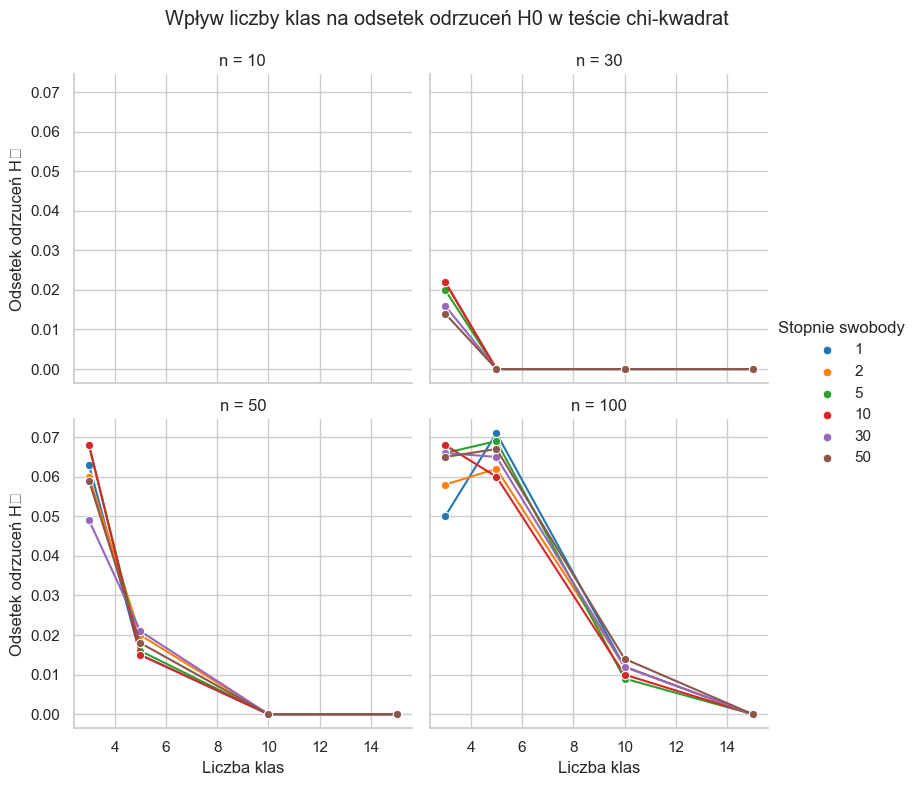

In [3]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set(style="whitegrid")

stopnie_swobody = [1, 2, 5, 10, 30, 50]  # Stopnie swobody (df)
n_values = [10, 30, 50, 100]             # Liczebność próbek
liczba_klas = [3, 5, 10, 15]             # Liczba przedziałów klasowych
k = 1000                                            # Liczba symulacji dla każdej kombinacji

def chi2_test_simulation(n, df, bins, k):
    rejections = []
    for i in range(k):
        sample_data = np.random.chisquare(df, size=n)
        breaks = np.quantile(sample_data, q=np.linspace(0, 1, bins+1))
        unique_breaks = np.unique(breaks)
        
        if len(unique_breaks) < 2:
            # Zbyt mało unikalnych przedziałów –> pomijamy
            continue

        # Obliczam obserwowane liczności
        obs, _ = np.histogram(sample_data, bins=unique_breaks)
        # Obliczam oczekiwane liczności
        expected = n * np.diff(stats.chi2.cdf(breaks, df))
        # Usuwam przedziały, w których oczekiwana liczność < 5, czyli nieprawidłowa
        valid = expected >= 5

        if np.sum(valid) <= 1:
            continue  # Za mało przedziałów do testu, tę iterację też pomijam
        
        obs_valid = obs[valid]
        exp_valid = expected[valid]
        # Normalizuje oczekiwane liczności
        exp_norm = exp_valid * (obs_valid.sum() / exp_valid.sum())
        try:
            _, p_val = stats.chisquare(f_obs=obs_valid, f_exp=exp_norm)
        except Exception:
            p_val = np.nan
        # Odrzucam H0, gdy p-value nie jest nan i p < 0.05
        if (not np.isnan(p_val)) and (p_val < 0.05):
            rejections.append(1)
        else:
            rejections.append(0)

    if len(rejections) == 0:
        # Jeśli żadna iteracja nie została wykonana poprawnie, zwracam nan
        return np.nan
    else:
        return np.mean(rejections)

results = []
for n in n_values:
    for df_val in stopnie_swobody:
        for bins in liczba_klas:
            rejection_rate = chi2_test_simulation(n, df_val, bins, k)
            results.append({
                "n": n,
                "df": df_val,
                "bins": bins,
                "rejection_rate": rejection_rate
            })

df_results = pd.DataFrame(results)
print(df_results.head())

g = sns.FacetGrid(df_results, col="n", col_wrap=2, hue="df", height=4, palette="tab10", margin_titles=True)
g.map(sns.lineplot, "bins", "rejection_rate", marker="o")
g.map(sns.scatterplot, "bins", "rejection_rate")

for ax in g.axes.flatten():
    ax.set_xlabel("Liczba klas")
    ax.set_ylabel("Odsetek odrzuceń H₀")

g.add_legend(title="Stopnie swobody")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Wpływ liczby klas na odsetek odrzuceń H0 w teście chi-kwadrat")
plt.show()